# Nature DQN (2015) 训练 Notebook

本 Notebook 用于训练 Nature DQN 智能体玩 Atari 游戏。

**2015 版本核心改进：**
- **Target Network**: 使用独立的目标网络计算 TD 目标
- **定期同步**: 每 10,000 步将主网络参数复制到目标网络
- **更大的网络**: 32-64-64 卷积层 + 512 全连接层
- **Huber Loss**: 比 MSE 更鲁棒

## 0. 导入到 Google Colab

In [ ]:
# 挂载 Google Drive 保存检查点
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Code/BIT-Embodied-Project/DQN-2015
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

## 1. 环境检查

In [ ]:
import sys
import os
import torch

sys.path.insert(0, '..')

# 自动检测设备（支持 CUDA、MPS、CPU）
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

DEVICE = get_device()

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"使用设备: {DEVICE}")

if DEVICE == 'cuda':
    print(f"CUDA: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif DEVICE == 'cpu':
    print("注意: 使用 CPU 训练会很慢，建议减少 total_frames 或使用 GPU")

## 2. 导入依赖

In [2]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
import time
import imageio

from envs import BreakoutEnv
from envs.wrappers import FrameStack, ClipRewardEnv
from dqn import DQNAgent

## 3. 训练配置

In [3]:
# 训练参数
CONFIG = {
    'total_frames': 50_000_000,     # 总训练帧数
    'log_interval': 10_000,          # 日志输出间隔
    'plot_interval': 50_000,         # 绘图更新间隔
    'eval_interval': 100_000,        # 评估间隔
    'save_interval': 500_000,        # 保存间隔
    'save_dir': 'checkpoints',       # 保存目录
}

print("训练配置:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

训练配置:
  total_frames: 50000000
  log_interval: 10000
  plot_interval: 50000
  eval_interval: 100000
  save_interval: 500000
  save_dir: checkpoints


## 4. 初始化环境和智能体

In [ ]:
from gymnasium.vector import AsyncVectorEnv
import multiprocessing as mp

# 使用 spawn 方式创建子进程（避免 CUDA fork 问题）
mp.set_start_method('spawn', force=True)

# 并行环境配置（CPU 模式下建议减少并行数）
NUM_ENVS = 8 if DEVICE == 'cuda' else 4

# 环境工厂函数
def make_env():
    env = BreakoutEnv()
    env = ClipRewardEnv(env)
    env = FrameStack(env, num_stack=4)
    return env

# 创建异步并行环境（真正的多进程并行）
envs = AsyncVectorEnv(
    [make_env for _ in range(NUM_ENVS)],
    shared_memory=True,  # 使用共享内存加速数据传输
)

# 获取动作空间
single_env = make_env()
n_actions = single_env.get_action_space()
single_env.close()
print(f"动作空间: {n_actions}")
print(f"并行环境数: {NUM_ENVS} (AsyncVectorEnv)")

# 创建 Nature DQN 智能体 (带 Target Network)
agent = DQNAgent(
    n_actions=n_actions,
    num_envs=NUM_ENVS,      # 传递并行环境数量
    device=DEVICE,          # 使用自动检测的设备
    target_update_freq=10_000,  # 每 10000 步同步目标网络
    use_compile=(DEVICE == 'cuda')  # 仅 CUDA 模式下使用编译加速
)
print(f"设备: {agent.device}")
print(f"Target Network 同步频率: {agent.target_update_freq}")

os.makedirs(CONFIG['save_dir'], exist_ok=True)

## 5. 定义绘图函数

In [5]:
def plot_progress(episode_rewards, losses, frame):
    """绘制训练进度"""
    clear_output(wait=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # 奖励曲线
    ax1 = axes[0]
    if len(episode_rewards) > 0:
        ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Episode')
        if len(episode_rewards) >= 100:
            window = 100
            avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(episode_rewards)), avg, color='red', label=f'{window}-ep avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Nature DQN (2015) - Frame: {frame:,}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 损失曲线
    ax2 = axes[1]
    if len(losses) > 0:
        ax2.plot(losses, alpha=0.5, color='green')
    ax2.set_xlabel('Update Steps')
    ax2.set_ylabel('Loss')
    ax2.set_title('Huber Loss')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. 训练循环

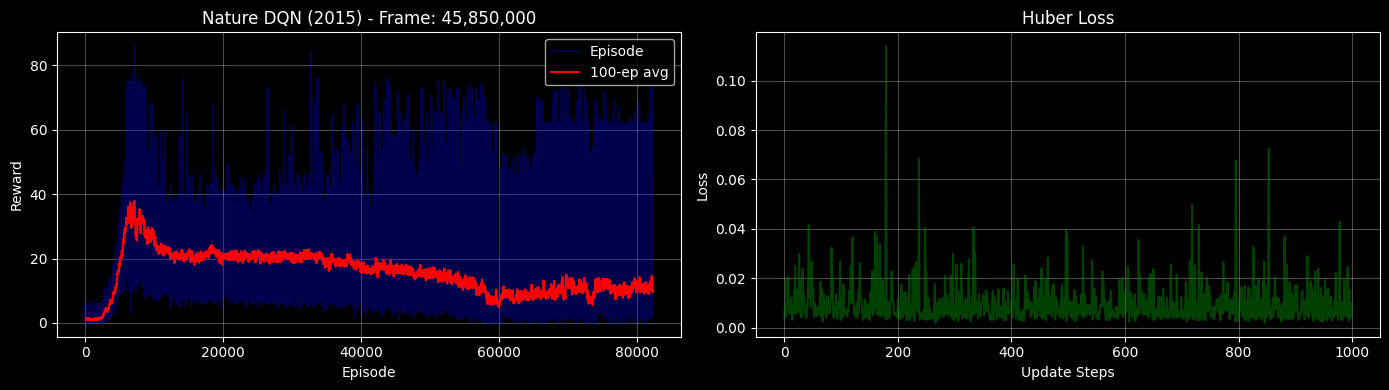

帧: 45,850,000 | 回合: 82328 | 平均奖励(100): 10.27 | epsilon: 0.100 | FPS: 484


In [ ]:
# 统计数据
episode_rewards = []
losses = []
episode_rewards_buffer = [0.0] * NUM_ENVS
episode_count = 0
best_avg_reward = float('-inf')  # 记录最佳平均奖励
states, _ = envs.reset()
start_time = time.time()

print("开始训练 Nature DQN (2015)...")

for step in range(1, CONFIG['total_frames'] // NUM_ENVS + 1):
    frame = step * NUM_ENVS
    agent.frame_count = frame
    
    # 批量选择动作
    actions = agent.select_actions_batch(states)
    
    # 执行动作
    next_states, rewards, terminateds, truncateds, infos = envs.step(actions)
    dones = terminateds | truncateds
    
    # 为每个环境存储单帧经验（内存优化：只存最新帧）
    for i in range(NUM_ENVS):
        current_frame = states[i][-1]  # 取堆叠状态的最新帧 (84, 84)
        agent.replay_buffer.push(current_frame, actions[i], rewards[i], dones[i], env_id=i)
        episode_rewards_buffer[i] += rewards[i]
        
        if dones[i]:
            episode_rewards.append(episode_rewards_buffer[i])
            episode_count += 1
            episode_rewards_buffer[i] = 0.0
    
    # 训练更新 (内部会自动同步 target network)
    loss = agent.update()
    if loss is not None:
        losses.append(loss)
    
    states = next_states
    
    # 日志
    if frame % CONFIG['plot_interval'] == 0:
        elapsed = time.time() - start_time
        fps = frame / elapsed
        plot_progress(episode_rewards, losses[-1000:], frame)
        
        current_avg = np.mean(episode_rewards[-100:]) if episode_rewards else 0
        print(f"帧: {frame:,} | 回合: {episode_count} | "
              f"平均奖励(100): {current_avg:.2f} | "
              f"epsilon: {agent.get_epsilon():.3f} | FPS: {fps:.0f}")
        
        # 保存最佳模型
        if len(episode_rewards) >= 100 and current_avg > best_avg_reward:
            best_avg_reward = current_avg
            agent.save(os.path.join(CONFIG['save_dir'], 'dqn_best.pt'))
            print(f"  -> 新最高分！已保存模型 (avg: {best_avg_reward:.2f})")

envs.close()
print("\n训练完成！")

## 7. 查看最终结果

In [ ]:
# 最终训练曲线
plot_progress(episode_rewards, losses[-1000:], CONFIG['total_frames'])

print(f"\n训练统计:")
print(f"  总回合数: {len(episode_rewards)}")
print(f"  最高奖励: {max(episode_rewards) if episode_rewards else 0:.2f}")
print(f"  最终 100 回合平均: {np.mean(episode_rewards[-100:]) if episode_rewards else 0:.2f}")

## 8. 评估训练好的智能体

In [ ]:
def evaluate(agent, n_episodes=10, save_video=True, video_dir='videos'):
    """评估智能体，可选保存视频"""
    eval_env = BreakoutEnv(render_mode='rgb_array' if save_video else None)
    eval_env = ClipRewardEnv(eval_env)
    eval_env = FrameStack(eval_env, num_stack=4)
    
    if save_video:
        os.makedirs(video_dir, exist_ok=True)
    
    rewards = []
    for ep in range(n_episodes):
        state, _ = eval_env.reset()
        total = 0
        done = False
        frames = []
        
        while not done:
            if save_video:
                frames.append(eval_env.unwrapped.ale.getScreenRGB())
            
            action = agent.select_action(state, eval_mode=True)
            state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            total += reward
        
        rewards.append(total)
        print(f"  回合 {ep+1}: {total:.2f}")
        
        if save_video and frames:
            video_path = os.path.join(video_dir, f'episode_{ep+1}.mp4')
            imageio.mimsave(video_path, frames, fps=30, macro_block_size=1)
            print(f"    视频已保存: {video_path}")
    
    eval_env.close()
    return np.mean(rewards), np.std(rewards)

print("评估中...")
mean_reward, std_reward = evaluate(agent, n_episodes=10, save_video=False)
print(f"\n评估结果: {mean_reward:.2f} ± {std_reward:.2f}")